# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Algorithms for a Dog Identification App 

---
### Goal of Project  

Develop an algorithm that could be used as part of a mobile or web app. This set of algorithm will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  

![Sample Dog Output](images/sample_dog_output.png)

### Table of Content 

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, I import a dataset of dog images.  I populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('/data/dog_images/train')
valid_files, valid_targets = load_dataset('/data/dog_images/valid')
test_files, test_targets = load_dataset('/data/dog_images/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("/data/dog_images/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, I import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("/data/lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

I use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  I have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, I demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


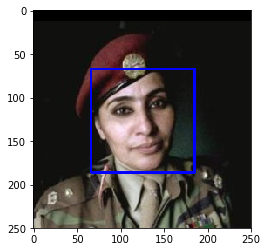

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

I use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, I would like 100% of human images with a detected face and 0% of dog images with a detected face.  This algorithm falls short of this goal, but still gives acceptable performance.  I extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
- 100% of the first 100 images in 'human_files' have a detected human face. 
- 11% of the first 100 images in 'dog_files' have a detected human face. 

In [5]:

human_files_short = human_files[:100]
dog_files_short = train_files[:100]


## Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
result_human = 0
for file in human_files_short:
    a = face_detector(file)
    if a:
        result_human += 1
    percent_human = result_human / len(human_files_short) * 100
result_dog = 0
for file in dog_files_short:
    b = face_detector(file)
    if b:
        result_dog += 1
    percent_dog = result_dog / len(dog_files_short) * 100
print('%d percent of the first 100 images in human_files have a detected human face.' % percent_human)
print('%d percent of the first 100 images in dog_files have a detected human face.' % percent_dog)

100 percent of the first 100 images in human_files have a detected human face.
11 percent of the first 100 images in dog_files have a detected human face.


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__
I think it is a somewhat reasonable expectation to pose on the user, but first need to define the threshhold level of clarity that is needed for human facial recognition with the algorithm. Also, it depends on the purpose of the recognition, whether it is solly for recognizing a human or the identity of a person. 

If it is just for recognizing a human, I don't think a clear view of a face is necessary. We can develop a algorithm to recognize human facial organs (i.e., eyes, nose, mouth, ears, and eyebrows). However, when it comes to identify a person from an image, we may need to test out the minimum level of clarity needed for such a function. For example, we can train and test the algorithm with images of various levels of clarity. By doing so, we can then evaluate the threshold for image clarity.

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, I use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  My first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [6]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

102858752/102853048 [==============================] - 1s 0us/step


### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which is also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in the dataset!

In [7]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  The code for `preprocess_input` can be found [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that I have a way to format the image for supplying to ResNet-50, I am now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which I can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [8]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), I notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, I need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

I use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [9]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

###  Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 
- 0 percent of the first 100 images in human_files have a detected dog.
- 100 percent of the first 100 images in dog_files have a detected dog.

In [10]:
### Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

outcome_human = 0
for file in human_files_short:
    c = dog_detector(file)
    if c: 
        outcome_human += 1
    percent_human = outcome_human / len(human_files_short) * 100

outcome_dog = 0
for file in dog_files_short:
    d = dog_detector(file)
    if d: 
        outcome_dog += 1
    percent_dog = outcome_dog / len(dog_files_short) * 100

print('%d percent of the first 100 images in human_files have a detected dog.' % percent_human)
print('%d percent of the first 100 images in dog_files have a detected dog.' % percent_dog)

0 percent of the first 100 images in human_files have a detected dog.
100 percent of the first 100 images in dog_files have a detected dog.


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

### Pre-process the Data

I rescale the images by dividing every pixel in every image by 255.

In [11]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:08<00:00, 102.46it/s]


### Image Augmentation

In [12]:
from keras.preprocessing.image import ImageDataGenerator

# create and configure augmented image generator
datagen = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True) # randomly flip images horizontally

# fit augmented image generator on data
datagen.fit(train_tensors)

###  Model Architecture

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 
A 3-layer CNN was created with each layer containing the following:

2x2 convolution
relu activation
2x2 max pooling
batchnormalization
The resulting tensor is followed by the following:

global average pooling
fully-connected layer
relu activation
softmax
The CNN takes 224 x 224 RGB (3 channels) image and outputs a vector of length 133, corresponding to the probability for each dog breed.

It was trained with RMSProp optimizer and categorical cross-entropy loss function.
After 100 epochs (>1.5hrs), best performing model based on the validation loss score was chosen, corresponding to 38.3% training accuracy and 39.5% validation accuracy.
Its performance on the test set was 38.6%.

In [13]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
model = Sequential()
model.add(BatchNormalization(input_shape=(224, 224, 3)))
### Define cnn architecture.
model.add(Conv2D(filters=16, kernel_size=2, padding='same', kernel_initializer='he_normal', activation='relu', input_shape = (224,224,3)))
model.add(MaxPooling2D(pool_size = 2))
model.add(BatchNormalization())

model.add(Conv2D(filters=32, kernel_size=2, padding='valid', kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(BatchNormalization())

model.add(Conv2D(filters=64, kernel_size=2, padding='valid', kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(BatchNormalization())


model.add(GlobalAveragePooling2D(batch_size = 64))

model.add(Dense(133, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 224, 224, 3)       12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 112, 112, 16)      64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 111, 111, 32)      2080      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 55, 55, 32)        128       
__________

### Compile the Model

In [14]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

###  Train the Model



In [15]:
from keras.callbacks import ModelCheckpoint  

### specify the number of epochs that is used to train the model.

epochs = 150





checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 28s 4ms/step - loss: 4.8228 - acc: 0.0193 - val_loss: 4.7837 - val_acc: 0.0240
Epoch 2/20
6680/6680 [==============================] - 27s 4ms/step - loss: 4.6988 - acc: 0.0337 - val_loss: 4.7119 - val_acc: 0.0347
Epoch 3/20
6680/6680 [==============================] - 27s 4ms/step - loss: 4.6349 - acc: 0.0404 - val_loss: 4.6492 - val_acc: 0.0383
Epoch 4/20
6680/6680 [==============================] - 27s 4ms/step - loss: 4.5863 - acc: 0.0451 - val_loss: 4.6228 - val_acc: 0.0407
Epoch 5/20
6680/6680 [==============================] - 27s 4ms/step - loss: 4.5506 - acc: 0.0509 - val_loss: 4.5936 - val_acc: 0.0455
Epoch 6/20
6680/6680 [==============================] - 27s 4ms/step - loss: 4.5201 - acc: 0.0554 - val_loss: 4.5723 - val_acc: 0.0455
Epoch 7/20
6680/6680 [==============================] - 27s 4ms/step - loss: 4.4956 - acc: 0.0564 - val_loss: 4.5722 - val_acc: 0.0407
Epoch 8/

### Load the Model with the Best Validation Loss

In [16]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model



In [17]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 7.6555%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will use transfer learning to train my own CNN.

### Obtain Bottleneck Features

In [18]:
bottleneck_features = np.load('/data/bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  I only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [19]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [20]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [21]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s 297us/step - loss: 11.9919 - acc: 0.1204 - val_loss: 10.0500 - val_acc: 0.2347
Epoch 2/20
6680/6680 [==============================] - 2s 242us/step - loss: 9.4411 - acc: 0.3027 - val_loss: 9.3332 - val_acc: 0.3018
Epoch 3/20
6680/6680 [==============================] - 2s 240us/step - loss: 8.8258 - acc: 0.3807 - val_loss: 9.1081 - val_acc: 0.3293
Epoch 4/20
6680/6680 [==============================] - 2s 241us/step - loss: 8.4629 - acc: 0.4109 - val_loss: 8.8114 - val_acc: 0.3521
Epoch 5/20
6680/6680 [==============================] - 2s 240us/step - loss: 8.1047 - acc: 0.4448 - val_loss: 8.7011 - val_acc: 0.3677
Epoch 6/20
6680/6680 [==============================] - 2s 241us/step - loss: 7.9603 - acc: 0.4705 - val_loss: 8.5530 - val_acc: 0.3820
Epoch 7/20
6680/6680 [==============================] - 2s 239us/step - loss: 7.8740 - acc: 0.4831 - val_loss: 8.5255 - val_acc: 0.3749

### Load the Model with the Best Validation Loss

In [22]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, I can use the CNN to test how well it identifies breed within our test dataset of dog images.  I print the test accuracy below.

In [23]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 43.5407%


### Predict Dog Breed with the Model

In [24]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

I will now use transfer learning to create a CNN that can identify dog breed from images.  My CNN must attain at least 60% accuracy on the test set.

In Step 4, I used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, I will the bottleneck features from a different pre-trained model.  


###  Obtain Bottleneck Features


In [28]:
### Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('/data/bottleneck_features/DogXceptionData.npz')
train = bottleneck_features['train']
valid = bottleneck_features['valid']
test = bottleneck_features['test']

###  Model Architecture


__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 



In [29]:
### Define my architecture.
model = Sequential()
model.add(GlobalAveragePooling2D(input_shape=train.shape[1:]))
model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


###  Compile the Model

In [30]:
### Compile the model.
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

Use model checkpointing to save the model that attains the best validation loss.  



In [35]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.test.hdf5', 
                               verbose=1, save_best_only=True)
epochs = 30
batch_size = 64
model.fit(train, train_targets, 
          validation_data=(valid, valid_targets),
          epochs=epochs, batch_size=batch_size, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/30
6680/6680 [==============================] - 2s 279us/step - loss: 0.0531 - acc: 0.9844 - val_loss: 0.7099 - val_acc: 0.8599
Epoch 2/30
6680/6680 [==============================] - 2s 281us/step - loss: 0.0433 - acc: 0.9885 - val_loss: 0.7090 - val_acc: 0.8443
Epoch 3/30
6680/6680 [==============================] - 2s 287us/step - loss: 0.0377 - acc: 0.9894 - val_loss: 0.6946 - val_acc: 0.8551
Epoch 4/30
6680/6680 [==============================] - 2s 284us/step - loss: 0.0314 - acc: 0.9919 - val_loss: 0.7013 - val_acc: 0.8551
Epoch 5/30
6680/6680 [==============================] - 2s 284us/step - loss: 0.0285 - acc: 0.9921 - val_loss: 0.7187 - val_acc: 0.8515
Epoch 6/30
6680/6680 [==============================] - 2s 281us/step - loss: 0.0254 - acc: 0.9934 - val_loss: 0.7090 - val_acc: 0.8527
Epoch 7/30
6680/6680 [==============================] - 2s 279us/step - loss: 0.0213 - acc: 0.9955 - val_loss: 0.7261 - val_acc: 0.8467
E

###  Load the Model with the Best Validation Loss

In [36]:
### Load the model weights with the best validation loss.
model.load_weights('saved_models/weights.best.test.hdf5')

### Test the Model



In [37]:
# get index of predicted dog breed for each image in test set
predictions = [np.argmax(model.predict(np.expand_dims(feature, axis=0))) for feature in test]

# report test accuracy
test_accuracy = 100*np.sum(np.array(predictions)==np.argmax(test_targets, axis=1))/len(predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 85.1675%


###  Predict Dog Breed with the Model

Here, I will write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by my model.  

Similar to the analogous function in Step 5, my function has the following three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  

In [42]:
### Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
from extract_bottleneck_features import *

def predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Xception(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    breed = dog_names[np.argmax(predicted_vector)]
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgplot = plt.imshow(cv_rgb)
    if dog_detector(img_path) == True:
        return print("The breed of dog is {}".format(breed))
    else:
        return print("If this person were a dog, the breed would be {}".format(breed))

---
<a id='step6'></a>
## Step 6: Write My Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.




In [43]:
### dog detector 
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 
### human face detector 
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0
### predictor 
def prediction(img_path):
    a = dog_detector(img_path)
    b = face_detector(img_path)
    if a: 
        print('A dog is detected in this image.')
        breed = predict_breed(img_path)
        return breed 
    if b:
        print('A human face is detected in this image.')
        breed = predict_breed(img_path)
        return breed
    else: 
        print('There is no dog or human detected in this image, please try another one.')
        img = cv2.imread(img_path)
        cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgplot = plt.imshow(cv_rgb)

---
<a id='step7'></a>
## Step 7: Test My Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

A dog is detected in this image.
The breed of dog is in/015.Basset_hound


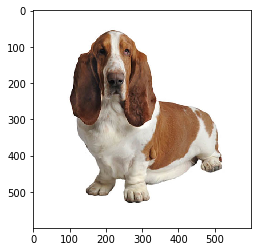

In [44]:
## Test 1
prediction('images/dog1.jpg')


A dog is detected in this image.
The breed of dog is in/126.Saint_bernard


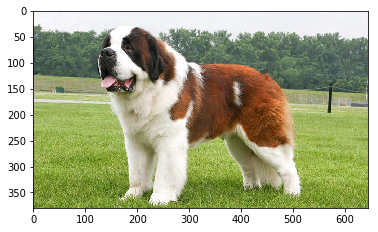

In [45]:
## test 2
prediction('images/dog2.jpg')

A human face is detected in this image.
If this person were a dog, the breed would be in/056.Dachshund


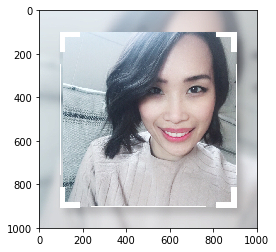

In [46]:
## test 3
prediction('images/face_1.jpg')

A dog is detected in this image.
The breed of dog is in/046.Cavalier_king_charles_spaniel


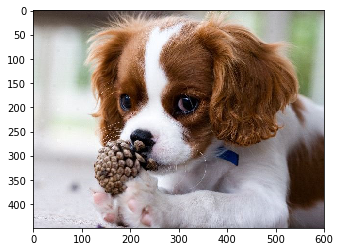

In [52]:
# test 4
prediction('images/dog_5.jpg')

A human face is detected in this image.
If this person were a dog, the breed would be in/044.Cane_corso


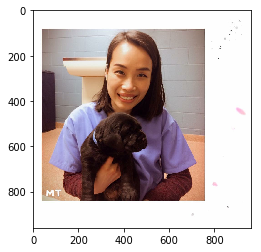

In [48]:
# test 5
prediction('images/human_dog.jpg')

A dog is detected in this image.
The breed of dog is in/019.Bedlington_terrier


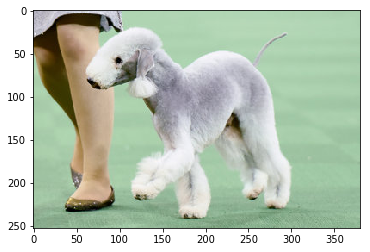

In [49]:
# test 6 
prediction('images/dog3.jpg')

A dog is detected in this image.
The breed of dog is in/096.Labrador_retriever


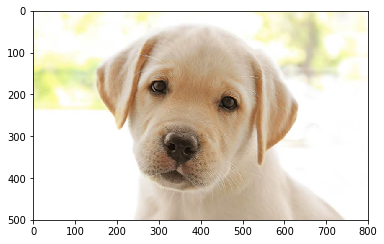

In [51]:
# test 7 
prediction('images/dog_3.jpg')